In [41]:


import random
from collections import deque
from numba import jit
import numpy as np


iteration = 1
time = 1
best = float('inf')
MEA_record = []


f = open(r"data.txt")
line = f.readline()
x = []
y = []
while line:
    num = list(map(float,line.split(',')))
    x.append(round(num[0],5))
    y.append(round(num[1],5))
    line = f.readline()
f.close()

x_train, y_train = np.array(x), np.array(y)
#x_valid, y_valid = np.array(x[600 :]), np.array(y[ 600 :])

def constant():
    p = random.random()
    if p > 0.3:
        return float(random.randint(-10, 10))
    else:
        return 'x'
@jit
def add(a, b):
    return np.add(a, b) 
@jit
def minus(a,b):
    return np.subtract(a,b)
@jit
def mul(a,b):
    return np.multiply(a,b)
@jit
def divd(a ,b):
        return np.divide(a, np.add(b,0.001))
@jit
def sin(a):
    return np.sin(a)
@jit
def cos(a):
    return np.cos(a)

operator = [add, minus, mul, divd, sin, cos]
population = 300

def fitness(a, b):
    difference = np.subtract(a,b)
    fitness = np.absolute(difference)
    total = np.sum(fitness, axis = 0)
    avg = np.divide(total, 600)
    return round(avg,6)

def generate(operator):
    p = random.random()
    if p > 0.35:
        return operator[random.randint(0,5)]
    else:
        return constant()

def createheap(operator):
    depth = 5
    output = []
    cur = 0
    
    q = deque([operator[random.randint(0,5)]])
        
    while cur <= depth:
        size = len(q)
        for _ in range(size):
            node = q.popleft()
            output.append(node)
            if node not in operator:
                q.append(None)
                q.append(None)
            elif cur == depth - 1:
                if node == operator[4] or node == operator[5]:
                    q.append('x')
                    q.append(None)
                else:
                    q.append(constant())
                    q.append('x')
            elif node == operator[4] or node == operator[5]:
                left_node = generate(operator)
                q.append(left_node)
                q.append(None)
            else:
                left_node = generate(operator)
                right_node = generate(operator)
                q.append(left_node)
                q.append(right_node)
        cur += 1 
        equation = output.copy()
    return output,  equation
            
def findconstant(matrix):
    candidate = []
    for i in range(len(matrix)):
        if type(matrix[i]) == float:
            candidate.append(i)

    return candidate

def mutation(matrix, candidate, operator, t):
    
    limit = 3
    for _ in range(limit):
        if len(candidate) != 0:
            for i in range(len(candidate)):
                idx = candidate[i]
                matrix[idx] += random.random()* random.randint(-10, 10)
                    
        
        idx = random.randint(0, 40)
        while matrix[idx] not in operator:
            idx = random.randint(0, 40)
      
        if matrix[idx] in operator[:4]:
            new = random.randint(0, 3)
            matrix[idx] = operator[new]
        elif matrix[idx] in operator[4:]:
            new = random.randint(4, 5)
            matrix[idx] = operator[new]
        
    return  matrix


def evaluate(matrix, x_train, operator):
    for i in range(len(matrix)-1, -1, -1):
        if matrix[i] == 'x':
            matrix[i] = x_train
        else:
            if matrix[i] == operator[4] or matrix[i] == operator[5]:
                if i == 0:
                    matrix[0] = matrix[0](matrix[1])
                else:
                    matrix[i] = matrix[i](matrix[2*i + 1])
            elif matrix[i] == operator[0] or matrix[i] == operator[1] or matrix[i] == operator[2] or matrix[i] == operator[3]:
                if i == 0:
                    matrix[0] = matrix[0](matrix[1], matrix[2])
                else:
                    matrix[i] = matrix[i](matrix[2*i + 1], matrix[2*i + 2])
    return matrix[0]

def find_crossingidx(matrix1, matrix2, operator):
    for j in range(len(matrix1) - 1, -1, -1):
        if matrix1[j] in operator:
            function1_idx = j
            break
        
    
    for i in range(len(matrix2) - 1, -1, -1):
        if matrix2[i] in operator:
            function2_idx = i
            break
    return [function1_idx, function2_idx]

def crossing(i, j, matrix1, matrix2):
    children = matrix1.copy()
    if children[i] not in operator[4:] and matrix2[j] not in operator[4:]:
        children[i], children[2*i + 1], children[2*i + 2] = matrix2[j], matrix2[2*j + 2], matrix2[2 *j +1]
    else:
        children[i], children[2*i + 1], children[2*i + 2] = matrix2[j], matrix2[2*j + 1], matrix2[2 *j + 2]
    return children
    
def rank(dic, y_train, x_train, operator):
    rank_dic = []
    output_dic = []
    totalpoint = []
    for i in range(600):
        result = evaluate(dic[i].copy(), x_train, operator)
        MEA = fitness(y_train, result)
        rank_dic.append([MEA, dic[i]])
        totalpoint.append(MEA)
    rank_dic = sorted(rank_dic, key = lambda x: x[0])
    
    count = 0
    for j in range(population):
        output_dic.append(rank_dic[j][1])
        if rank_dic[j][0] <= 0.8:
            count += 1 / 300
    return output_dic, rank_dic[0][0], round(count, 3), totalpoint
    

initial_dictionary = []

for i in range(population):
    output, equation = createheap(operator)
    initial_dictionary.append(output)
#print(dictionary[0])
#print('-----------------------------------------------------------')
#print(dictionary)
#print('---------------------------------------------------------------')

for _ in range(1):
    cur = []
    valid = []
    convergence = []
    dictionary = initial_dictionary.copy()
    complexityList = []
    dotList = []
    for t in range(10000):

        for _ in range(population//5):
            idx_0 = random.randint(0, 199)
            idx_1 = random.randint(0, 299)
            i , j = find_crossingidx(dictionary[ idx_0 ], dictionary[ idx_1 ], operator)
            first_children = crossing(i, j, dictionary[idx_0], dictionary[ idx_1 ])
            i2 , j2 = find_crossingidx(dictionary[ idx_1 ], dictionary[ idx_0 ], operator)
            second_children = crossing(i2, j2, dictionary[ idx_1 ], dictionary[ idx_0 ])

            candidate0 = findconstant(first_children)
            candidate1 = findconstant(second_children)
            mutated0 = mutation(first_children, candidate0, operator,t)
            mutated1 = mutation(second_children, candidate1, operator, t)
            dictionary.append(mutated0)
            dictionary.append(mutated1)
            
           
        for _ in range(100):
            fresh, fresh_equation = createheap(operator)
            dictionary.append(fresh)
        
        
        dictionary, Best_MEA, propotion, dot = rank(dictionary, y_train, x_train, operator)
        #if t in [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]:
        #    result = evaluate(dictionary[0].copy(), x_valid, operator)
        #    MEA_valid = fitness(y_valid, result)
        #    valid.append(MEA_valid)
        dotList.append(dot)
        cur.append((Best_MEA))
        convergence.append(propotion)
        empty = 0
        for slot in dictionary[0].copy():
            if slot == None:
                empty+=1
        complexity = len(dictionary[0].copy()) - empty
        complexityList.append(complexity)
        print('evol : {},  MEA is {},  convergence : {}'.format(t, Best_MEA, propotion))
    MEA_record.append(cur)
        #print(dictionary)
        #print(sorted_order)
        #print('------------------------------------------------------')
    np.savetxt("MAE.mat", np.array(cur), fmt="%s")

#print(MEA_record)
#print(dictionary[0])
EA_RANK = evaluate(dictionary[0].copy(), x_train, operator)
#print(MEA_record)
#print(predict_y[:5])
np.savetxt("EA_rank_final.mat", np.array(EA_RANK), fmt="%s")
np.savetxt("convergence.mat", np.array(convergence), fmt="%s")


evol : 0,  MEA is 3.306582,  convergence : 0
evol : 1,  MEA is 3.306582,  convergence : 0
evol : 2,  MEA is 3.306582,  convergence : 0
evol : 3,  MEA is 3.147503,  convergence : 0
evol : 4,  MEA is 3.147503,  convergence : 0
evol : 5,  MEA is 3.145209,  convergence : 0
evol : 6,  MEA is 3.132897,  convergence : 0
evol : 7,  MEA is 3.132897,  convergence : 0
evol : 8,  MEA is 3.132897,  convergence : 0
evol : 9,  MEA is 3.132897,  convergence : 0
evol : 10,  MEA is 3.132897,  convergence : 0
evol : 11,  MEA is 3.056981,  convergence : 0
evol : 12,  MEA is 2.961,  convergence : 0
evol : 13,  MEA is 2.961,  convergence : 0
evol : 14,  MEA is 2.961,  convergence : 0
evol : 15,  MEA is 2.961,  convergence : 0
evol : 16,  MEA is 2.961,  convergence : 0
evol : 17,  MEA is 2.961,  convergence : 0
evol : 18,  MEA is 2.870556,  convergence : 0
evol : 19,  MEA is 2.870556,  convergence : 0
evol : 20,  MEA is 2.870556,  convergence : 0
evol : 21,  MEA is 2.870556,  convergence : 0
evol : 22,  MEA 

evol : 178,  MEA is 2.198163,  convergence : 0
evol : 179,  MEA is 2.198163,  convergence : 0
evol : 180,  MEA is 2.198163,  convergence : 0
evol : 181,  MEA is 2.198163,  convergence : 0
evol : 182,  MEA is 2.198163,  convergence : 0
evol : 183,  MEA is 2.198163,  convergence : 0
evol : 184,  MEA is 2.198163,  convergence : 0
evol : 185,  MEA is 2.198163,  convergence : 0
evol : 186,  MEA is 2.198163,  convergence : 0
evol : 187,  MEA is 2.198163,  convergence : 0
evol : 188,  MEA is 2.198163,  convergence : 0
evol : 189,  MEA is 2.198163,  convergence : 0
evol : 190,  MEA is 2.198163,  convergence : 0
evol : 191,  MEA is 2.198163,  convergence : 0
evol : 192,  MEA is 2.198163,  convergence : 0
evol : 193,  MEA is 2.198163,  convergence : 0
evol : 194,  MEA is 2.198163,  convergence : 0
evol : 195,  MEA is 2.198163,  convergence : 0
evol : 196,  MEA is 2.198163,  convergence : 0
evol : 197,  MEA is 2.198163,  convergence : 0
evol : 198,  MEA is 2.198163,  convergence : 0
evol : 199,  

evol : 356,  MEA is 2.12928,  convergence : 0
evol : 357,  MEA is 2.12928,  convergence : 0
evol : 358,  MEA is 2.12928,  convergence : 0
evol : 359,  MEA is 2.12928,  convergence : 0
evol : 360,  MEA is 2.12928,  convergence : 0
evol : 361,  MEA is 2.12928,  convergence : 0
evol : 362,  MEA is 2.12928,  convergence : 0
evol : 363,  MEA is 2.12928,  convergence : 0
evol : 364,  MEA is 2.12928,  convergence : 0
evol : 365,  MEA is 2.12928,  convergence : 0
evol : 366,  MEA is 2.12928,  convergence : 0
evol : 367,  MEA is 2.12928,  convergence : 0
evol : 368,  MEA is 2.12928,  convergence : 0
evol : 369,  MEA is 2.12928,  convergence : 0
evol : 370,  MEA is 2.12928,  convergence : 0
evol : 371,  MEA is 2.12928,  convergence : 0
evol : 372,  MEA is 2.12928,  convergence : 0
evol : 373,  MEA is 2.12928,  convergence : 0
evol : 374,  MEA is 2.12928,  convergence : 0
evol : 375,  MEA is 2.12928,  convergence : 0
evol : 376,  MEA is 2.12928,  convergence : 0
evol : 377,  MEA is 2.12928,  conv

evol : 535,  MEA is 2.12928,  convergence : 0
evol : 536,  MEA is 2.12928,  convergence : 0
evol : 537,  MEA is 2.12928,  convergence : 0
evol : 538,  MEA is 2.12928,  convergence : 0
evol : 539,  MEA is 2.12928,  convergence : 0
evol : 540,  MEA is 2.12928,  convergence : 0
evol : 541,  MEA is 2.12928,  convergence : 0
evol : 542,  MEA is 2.12928,  convergence : 0
evol : 543,  MEA is 2.12928,  convergence : 0
evol : 544,  MEA is 2.12928,  convergence : 0
evol : 545,  MEA is 2.12928,  convergence : 0
evol : 546,  MEA is 2.12928,  convergence : 0
evol : 547,  MEA is 2.12928,  convergence : 0
evol : 548,  MEA is 2.12928,  convergence : 0
evol : 549,  MEA is 2.12928,  convergence : 0
evol : 550,  MEA is 2.12928,  convergence : 0
evol : 551,  MEA is 2.12928,  convergence : 0
evol : 552,  MEA is 2.12928,  convergence : 0
evol : 553,  MEA is 2.12928,  convergence : 0
evol : 554,  MEA is 2.12928,  convergence : 0
evol : 555,  MEA is 2.12928,  convergence : 0
evol : 556,  MEA is 2.12928,  conv

evol : 714,  MEA is 2.12928,  convergence : 0
evol : 715,  MEA is 2.12928,  convergence : 0
evol : 716,  MEA is 2.12928,  convergence : 0
evol : 717,  MEA is 2.12928,  convergence : 0
evol : 718,  MEA is 2.12928,  convergence : 0
evol : 719,  MEA is 2.12928,  convergence : 0
evol : 720,  MEA is 2.12928,  convergence : 0
evol : 721,  MEA is 2.12928,  convergence : 0
evol : 722,  MEA is 2.12928,  convergence : 0
evol : 723,  MEA is 2.12928,  convergence : 0
evol : 724,  MEA is 2.12928,  convergence : 0
evol : 725,  MEA is 2.12928,  convergence : 0
evol : 726,  MEA is 2.12928,  convergence : 0
evol : 727,  MEA is 2.12928,  convergence : 0
evol : 728,  MEA is 2.12928,  convergence : 0
evol : 729,  MEA is 2.12928,  convergence : 0
evol : 730,  MEA is 2.12928,  convergence : 0
evol : 731,  MEA is 2.12928,  convergence : 0
evol : 732,  MEA is 2.12928,  convergence : 0
evol : 733,  MEA is 2.12928,  convergence : 0
evol : 734,  MEA is 2.12928,  convergence : 0
evol : 735,  MEA is 2.12928,  conv

evol : 890,  MEA is 1.736016,  convergence : 0
evol : 891,  MEA is 1.736016,  convergence : 0
evol : 892,  MEA is 1.736016,  convergence : 0
evol : 893,  MEA is 1.736016,  convergence : 0
evol : 894,  MEA is 1.736016,  convergence : 0
evol : 895,  MEA is 1.736016,  convergence : 0
evol : 896,  MEA is 1.736016,  convergence : 0
evol : 897,  MEA is 1.736016,  convergence : 0
evol : 898,  MEA is 1.736016,  convergence : 0
evol : 899,  MEA is 1.736016,  convergence : 0
evol : 900,  MEA is 1.736016,  convergence : 0
evol : 901,  MEA is 1.736016,  convergence : 0
evol : 902,  MEA is 1.736016,  convergence : 0
evol : 903,  MEA is 1.736016,  convergence : 0
evol : 904,  MEA is 1.736016,  convergence : 0
evol : 905,  MEA is 1.736016,  convergence : 0
evol : 906,  MEA is 1.736016,  convergence : 0
evol : 907,  MEA is 1.736016,  convergence : 0
evol : 908,  MEA is 1.736016,  convergence : 0
evol : 909,  MEA is 1.736016,  convergence : 0
evol : 910,  MEA is 1.736016,  convergence : 0
evol : 911,  

evol : 1063,  MEA is 1.736016,  convergence : 0
evol : 1064,  MEA is 1.736016,  convergence : 0
evol : 1065,  MEA is 1.736016,  convergence : 0
evol : 1066,  MEA is 1.736016,  convergence : 0
evol : 1067,  MEA is 1.736016,  convergence : 0
evol : 1068,  MEA is 1.736016,  convergence : 0
evol : 1069,  MEA is 1.736016,  convergence : 0
evol : 1070,  MEA is 1.736016,  convergence : 0
evol : 1071,  MEA is 1.736016,  convergence : 0
evol : 1072,  MEA is 1.736016,  convergence : 0
evol : 1073,  MEA is 1.736016,  convergence : 0
evol : 1074,  MEA is 1.736016,  convergence : 0
evol : 1075,  MEA is 1.736016,  convergence : 0
evol : 1076,  MEA is 1.736016,  convergence : 0
evol : 1077,  MEA is 1.736016,  convergence : 0
evol : 1078,  MEA is 1.736016,  convergence : 0
evol : 1079,  MEA is 1.736016,  convergence : 0
evol : 1080,  MEA is 1.736016,  convergence : 0
evol : 1081,  MEA is 1.736016,  convergence : 0
evol : 1082,  MEA is 1.736016,  convergence : 0
evol : 1083,  MEA is 1.736016,  converge

evol : 1234,  MEA is 1.736016,  convergence : 0
evol : 1235,  MEA is 1.736016,  convergence : 0
evol : 1236,  MEA is 1.736016,  convergence : 0
evol : 1237,  MEA is 1.736016,  convergence : 0
evol : 1238,  MEA is 1.736016,  convergence : 0
evol : 1239,  MEA is 1.736016,  convergence : 0
evol : 1240,  MEA is 1.736016,  convergence : 0
evol : 1241,  MEA is 1.736016,  convergence : 0
evol : 1242,  MEA is 1.736016,  convergence : 0
evol : 1243,  MEA is 1.736016,  convergence : 0
evol : 1244,  MEA is 1.736016,  convergence : 0
evol : 1245,  MEA is 1.736016,  convergence : 0
evol : 1246,  MEA is 1.736016,  convergence : 0
evol : 1247,  MEA is 1.736016,  convergence : 0
evol : 1248,  MEA is 1.736016,  convergence : 0
evol : 1249,  MEA is 1.736016,  convergence : 0
evol : 1250,  MEA is 1.736016,  convergence : 0
evol : 1251,  MEA is 1.736016,  convergence : 0
evol : 1252,  MEA is 1.736016,  convergence : 0
evol : 1253,  MEA is 1.736016,  convergence : 0
evol : 1254,  MEA is 1.736016,  converge

evol : 1406,  MEA is 1.494521,  convergence : 0
evol : 1407,  MEA is 1.494521,  convergence : 0
evol : 1408,  MEA is 1.494521,  convergence : 0
evol : 1409,  MEA is 1.494521,  convergence : 0
evol : 1410,  MEA is 1.494521,  convergence : 0
evol : 1411,  MEA is 1.494521,  convergence : 0
evol : 1412,  MEA is 1.494521,  convergence : 0
evol : 1413,  MEA is 1.494521,  convergence : 0
evol : 1414,  MEA is 1.494521,  convergence : 0
evol : 1415,  MEA is 1.494521,  convergence : 0
evol : 1416,  MEA is 1.494521,  convergence : 0
evol : 1417,  MEA is 1.494521,  convergence : 0
evol : 1418,  MEA is 1.494521,  convergence : 0
evol : 1419,  MEA is 1.494521,  convergence : 0
evol : 1420,  MEA is 1.494521,  convergence : 0
evol : 1421,  MEA is 1.494521,  convergence : 0
evol : 1422,  MEA is 1.494521,  convergence : 0
evol : 1423,  MEA is 1.494521,  convergence : 0
evol : 1424,  MEA is 1.494521,  convergence : 0
evol : 1425,  MEA is 1.494521,  convergence : 0
evol : 1426,  MEA is 1.494521,  converge

evol : 1577,  MEA is 1.463115,  convergence : 0
evol : 1578,  MEA is 1.463115,  convergence : 0
evol : 1579,  MEA is 1.463115,  convergence : 0
evol : 1580,  MEA is 1.463115,  convergence : 0
evol : 1581,  MEA is 1.463115,  convergence : 0
evol : 1582,  MEA is 1.463115,  convergence : 0
evol : 1583,  MEA is 1.463115,  convergence : 0
evol : 1584,  MEA is 1.463115,  convergence : 0
evol : 1585,  MEA is 1.463115,  convergence : 0
evol : 1586,  MEA is 1.463115,  convergence : 0
evol : 1587,  MEA is 1.463115,  convergence : 0
evol : 1588,  MEA is 1.463115,  convergence : 0
evol : 1589,  MEA is 1.463115,  convergence : 0
evol : 1590,  MEA is 1.463115,  convergence : 0
evol : 1591,  MEA is 1.463115,  convergence : 0
evol : 1592,  MEA is 1.463115,  convergence : 0
evol : 1593,  MEA is 1.463115,  convergence : 0
evol : 1594,  MEA is 1.463115,  convergence : 0
evol : 1595,  MEA is 1.463115,  convergence : 0
evol : 1596,  MEA is 1.463115,  convergence : 0
evol : 1597,  MEA is 1.463115,  converge

evol : 1749,  MEA is 1.017968,  convergence : 0
evol : 1750,  MEA is 1.017968,  convergence : 0
evol : 1751,  MEA is 1.017968,  convergence : 0
evol : 1752,  MEA is 1.017968,  convergence : 0
evol : 1753,  MEA is 1.017968,  convergence : 0
evol : 1754,  MEA is 1.017968,  convergence : 0
evol : 1755,  MEA is 1.017968,  convergence : 0
evol : 1756,  MEA is 1.017968,  convergence : 0
evol : 1757,  MEA is 1.017968,  convergence : 0
evol : 1758,  MEA is 1.017968,  convergence : 0
evol : 1759,  MEA is 1.017968,  convergence : 0
evol : 1760,  MEA is 1.017968,  convergence : 0
evol : 1761,  MEA is 1.017968,  convergence : 0
evol : 1762,  MEA is 1.017968,  convergence : 0
evol : 1763,  MEA is 1.017968,  convergence : 0
evol : 1764,  MEA is 1.017968,  convergence : 0
evol : 1765,  MEA is 1.017968,  convergence : 0
evol : 1766,  MEA is 1.017968,  convergence : 0
evol : 1767,  MEA is 1.017968,  convergence : 0
evol : 1768,  MEA is 1.017968,  convergence : 0
evol : 1769,  MEA is 1.017968,  converge

evol : 1923,  MEA is 1.017968,  convergence : 0
evol : 1924,  MEA is 1.017968,  convergence : 0
evol : 1925,  MEA is 1.017968,  convergence : 0
evol : 1926,  MEA is 1.017968,  convergence : 0
evol : 1927,  MEA is 1.017968,  convergence : 0
evol : 1928,  MEA is 1.017968,  convergence : 0
evol : 1929,  MEA is 1.017968,  convergence : 0
evol : 1930,  MEA is 1.017968,  convergence : 0
evol : 1931,  MEA is 1.017968,  convergence : 0
evol : 1932,  MEA is 1.017968,  convergence : 0
evol : 1933,  MEA is 1.017968,  convergence : 0
evol : 1934,  MEA is 1.017968,  convergence : 0
evol : 1935,  MEA is 1.017968,  convergence : 0
evol : 1936,  MEA is 1.017968,  convergence : 0
evol : 1937,  MEA is 1.017968,  convergence : 0
evol : 1938,  MEA is 1.017968,  convergence : 0
evol : 1939,  MEA is 1.017968,  convergence : 0
evol : 1940,  MEA is 1.017968,  convergence : 0
evol : 1941,  MEA is 1.017968,  convergence : 0
evol : 1942,  MEA is 1.017968,  convergence : 0
evol : 1943,  MEA is 1.017968,  converge

evol : 2097,  MEA is 1.017968,  convergence : 0
evol : 2098,  MEA is 1.017968,  convergence : 0
evol : 2099,  MEA is 1.017968,  convergence : 0
evol : 2100,  MEA is 1.017968,  convergence : 0
evol : 2101,  MEA is 1.017968,  convergence : 0
evol : 2102,  MEA is 1.017968,  convergence : 0
evol : 2103,  MEA is 1.017968,  convergence : 0
evol : 2104,  MEA is 1.017968,  convergence : 0
evol : 2105,  MEA is 1.017968,  convergence : 0
evol : 2106,  MEA is 1.017968,  convergence : 0
evol : 2107,  MEA is 1.017968,  convergence : 0
evol : 2108,  MEA is 1.017968,  convergence : 0
evol : 2109,  MEA is 1.017968,  convergence : 0
evol : 2110,  MEA is 1.017968,  convergence : 0
evol : 2111,  MEA is 1.017968,  convergence : 0
evol : 2112,  MEA is 1.017968,  convergence : 0
evol : 2113,  MEA is 1.017968,  convergence : 0
evol : 2114,  MEA is 1.017968,  convergence : 0
evol : 2115,  MEA is 1.017968,  convergence : 0
evol : 2116,  MEA is 1.017968,  convergence : 0
evol : 2117,  MEA is 1.001072,  converge

evol : 2268,  MEA is 0.889974,  convergence : 0
evol : 2269,  MEA is 0.889974,  convergence : 0
evol : 2270,  MEA is 0.889974,  convergence : 0
evol : 2271,  MEA is 0.889974,  convergence : 0
evol : 2272,  MEA is 0.889974,  convergence : 0
evol : 2273,  MEA is 0.889974,  convergence : 0
evol : 2274,  MEA is 0.889974,  convergence : 0
evol : 2275,  MEA is 0.889974,  convergence : 0
evol : 2276,  MEA is 0.889974,  convergence : 0
evol : 2277,  MEA is 0.889974,  convergence : 0
evol : 2278,  MEA is 0.889974,  convergence : 0
evol : 2279,  MEA is 0.889974,  convergence : 0
evol : 2280,  MEA is 0.889974,  convergence : 0
evol : 2281,  MEA is 0.889974,  convergence : 0
evol : 2282,  MEA is 0.889974,  convergence : 0
evol : 2283,  MEA is 0.889974,  convergence : 0
evol : 2284,  MEA is 0.889974,  convergence : 0
evol : 2285,  MEA is 0.889974,  convergence : 0
evol : 2286,  MEA is 0.889974,  convergence : 0
evol : 2287,  MEA is 0.889974,  convergence : 0
evol : 2288,  MEA is 0.889974,  converge

evol : 2442,  MEA is 0.889974,  convergence : 0
evol : 2443,  MEA is 0.889974,  convergence : 0
evol : 2444,  MEA is 0.889974,  convergence : 0
evol : 2445,  MEA is 0.889974,  convergence : 0
evol : 2446,  MEA is 0.889974,  convergence : 0
evol : 2447,  MEA is 0.889974,  convergence : 0
evol : 2448,  MEA is 0.889974,  convergence : 0
evol : 2449,  MEA is 0.889974,  convergence : 0
evol : 2450,  MEA is 0.889974,  convergence : 0
evol : 2451,  MEA is 0.889974,  convergence : 0
evol : 2452,  MEA is 0.889974,  convergence : 0
evol : 2453,  MEA is 0.889974,  convergence : 0
evol : 2454,  MEA is 0.889974,  convergence : 0
evol : 2455,  MEA is 0.889974,  convergence : 0
evol : 2456,  MEA is 0.889974,  convergence : 0
evol : 2457,  MEA is 0.889974,  convergence : 0
evol : 2458,  MEA is 0.889974,  convergence : 0
evol : 2459,  MEA is 0.889974,  convergence : 0
evol : 2460,  MEA is 0.889974,  convergence : 0
evol : 2461,  MEA is 0.889974,  convergence : 0
evol : 2462,  MEA is 0.889974,  converge

evol : 2615,  MEA is 0.889974,  convergence : 0
evol : 2616,  MEA is 0.889974,  convergence : 0
evol : 2617,  MEA is 0.889974,  convergence : 0
evol : 2618,  MEA is 0.889974,  convergence : 0
evol : 2619,  MEA is 0.889974,  convergence : 0
evol : 2620,  MEA is 0.889974,  convergence : 0
evol : 2621,  MEA is 0.889974,  convergence : 0
evol : 2622,  MEA is 0.889974,  convergence : 0
evol : 2623,  MEA is 0.889974,  convergence : 0
evol : 2624,  MEA is 0.889974,  convergence : 0
evol : 2625,  MEA is 0.889974,  convergence : 0
evol : 2626,  MEA is 0.889974,  convergence : 0
evol : 2627,  MEA is 0.889974,  convergence : 0
evol : 2628,  MEA is 0.889974,  convergence : 0
evol : 2629,  MEA is 0.889974,  convergence : 0
evol : 2630,  MEA is 0.889974,  convergence : 0
evol : 2631,  MEA is 0.889974,  convergence : 0
evol : 2632,  MEA is 0.889974,  convergence : 0
evol : 2633,  MEA is 0.889974,  convergence : 0
evol : 2634,  MEA is 0.889974,  convergence : 0
evol : 2635,  MEA is 0.889974,  converge

evol : 2791,  MEA is 0.889974,  convergence : 0
evol : 2792,  MEA is 0.889974,  convergence : 0
evol : 2793,  MEA is 0.889974,  convergence : 0
evol : 2794,  MEA is 0.889974,  convergence : 0
evol : 2795,  MEA is 0.889974,  convergence : 0
evol : 2796,  MEA is 0.889974,  convergence : 0
evol : 2797,  MEA is 0.889974,  convergence : 0
evol : 2798,  MEA is 0.889974,  convergence : 0
evol : 2799,  MEA is 0.889974,  convergence : 0
evol : 2800,  MEA is 0.889974,  convergence : 0
evol : 2801,  MEA is 0.889974,  convergence : 0
evol : 2802,  MEA is 0.889974,  convergence : 0
evol : 2803,  MEA is 0.889974,  convergence : 0
evol : 2804,  MEA is 0.889974,  convergence : 0
evol : 2805,  MEA is 0.889974,  convergence : 0
evol : 2806,  MEA is 0.889974,  convergence : 0
evol : 2807,  MEA is 0.889974,  convergence : 0
evol : 2808,  MEA is 0.889974,  convergence : 0
evol : 2809,  MEA is 0.889974,  convergence : 0
evol : 2810,  MEA is 0.889974,  convergence : 0
evol : 2811,  MEA is 0.889974,  converge

evol : 2963,  MEA is 0.889974,  convergence : 0
evol : 2964,  MEA is 0.889974,  convergence : 0
evol : 2965,  MEA is 0.889974,  convergence : 0
evol : 2966,  MEA is 0.889974,  convergence : 0
evol : 2967,  MEA is 0.889974,  convergence : 0
evol : 2968,  MEA is 0.889974,  convergence : 0
evol : 2969,  MEA is 0.889974,  convergence : 0
evol : 2970,  MEA is 0.889974,  convergence : 0
evol : 2971,  MEA is 0.889974,  convergence : 0
evol : 2972,  MEA is 0.889974,  convergence : 0
evol : 2973,  MEA is 0.889974,  convergence : 0
evol : 2974,  MEA is 0.889974,  convergence : 0
evol : 2975,  MEA is 0.889974,  convergence : 0
evol : 2976,  MEA is 0.889974,  convergence : 0
evol : 2977,  MEA is 0.889974,  convergence : 0
evol : 2978,  MEA is 0.889974,  convergence : 0
evol : 2979,  MEA is 0.889974,  convergence : 0
evol : 2980,  MEA is 0.889974,  convergence : 0
evol : 2981,  MEA is 0.889974,  convergence : 0
evol : 2982,  MEA is 0.889974,  convergence : 0
evol : 2983,  MEA is 0.889974,  converge

evol : 3135,  MEA is 0.889974,  convergence : 0
evol : 3136,  MEA is 0.889974,  convergence : 0
evol : 3137,  MEA is 0.889974,  convergence : 0
evol : 3138,  MEA is 0.889974,  convergence : 0
evol : 3139,  MEA is 0.889974,  convergence : 0
evol : 3140,  MEA is 0.889974,  convergence : 0
evol : 3141,  MEA is 0.889974,  convergence : 0
evol : 3142,  MEA is 0.889974,  convergence : 0
evol : 3143,  MEA is 0.889974,  convergence : 0
evol : 3144,  MEA is 0.889974,  convergence : 0
evol : 3145,  MEA is 0.889974,  convergence : 0
evol : 3146,  MEA is 0.889974,  convergence : 0
evol : 3147,  MEA is 0.889974,  convergence : 0
evol : 3148,  MEA is 0.889974,  convergence : 0
evol : 3149,  MEA is 0.889974,  convergence : 0
evol : 3150,  MEA is 0.889974,  convergence : 0
evol : 3151,  MEA is 0.889974,  convergence : 0
evol : 3152,  MEA is 0.889974,  convergence : 0
evol : 3153,  MEA is 0.889974,  convergence : 0
evol : 3154,  MEA is 0.889974,  convergence : 0
evol : 3155,  MEA is 0.889974,  converge

evol : 3309,  MEA is 0.889974,  convergence : 0
evol : 3310,  MEA is 0.889974,  convergence : 0
evol : 3311,  MEA is 0.889974,  convergence : 0
evol : 3312,  MEA is 0.889974,  convergence : 0
evol : 3313,  MEA is 0.889974,  convergence : 0
evol : 3314,  MEA is 0.889974,  convergence : 0
evol : 3315,  MEA is 0.889974,  convergence : 0
evol : 3316,  MEA is 0.889974,  convergence : 0
evol : 3317,  MEA is 0.889974,  convergence : 0
evol : 3318,  MEA is 0.889974,  convergence : 0
evol : 3319,  MEA is 0.889974,  convergence : 0
evol : 3320,  MEA is 0.889974,  convergence : 0
evol : 3321,  MEA is 0.889974,  convergence : 0
evol : 3322,  MEA is 0.889974,  convergence : 0
evol : 3323,  MEA is 0.889974,  convergence : 0
evol : 3324,  MEA is 0.889974,  convergence : 0
evol : 3325,  MEA is 0.889974,  convergence : 0
evol : 3326,  MEA is 0.889974,  convergence : 0
evol : 3327,  MEA is 0.889974,  convergence : 0
evol : 3328,  MEA is 0.889974,  convergence : 0
evol : 3329,  MEA is 0.889974,  converge

evol : 3482,  MEA is 0.889974,  convergence : 0
evol : 3483,  MEA is 0.889974,  convergence : 0
evol : 3484,  MEA is 0.889974,  convergence : 0
evol : 3485,  MEA is 0.889974,  convergence : 0
evol : 3486,  MEA is 0.889974,  convergence : 0
evol : 3487,  MEA is 0.889974,  convergence : 0
evol : 3488,  MEA is 0.889974,  convergence : 0
evol : 3489,  MEA is 0.889974,  convergence : 0
evol : 3490,  MEA is 0.889974,  convergence : 0
evol : 3491,  MEA is 0.889974,  convergence : 0
evol : 3492,  MEA is 0.889974,  convergence : 0
evol : 3493,  MEA is 0.889974,  convergence : 0
evol : 3494,  MEA is 0.889974,  convergence : 0
evol : 3495,  MEA is 0.889974,  convergence : 0
evol : 3496,  MEA is 0.889974,  convergence : 0
evol : 3497,  MEA is 0.889974,  convergence : 0
evol : 3498,  MEA is 0.889974,  convergence : 0
evol : 3499,  MEA is 0.889974,  convergence : 0
evol : 3500,  MEA is 0.889974,  convergence : 0
evol : 3501,  MEA is 0.889974,  convergence : 0
evol : 3502,  MEA is 0.889974,  converge

evol : 3654,  MEA is 0.889974,  convergence : 0
evol : 3655,  MEA is 0.889974,  convergence : 0
evol : 3656,  MEA is 0.889974,  convergence : 0
evol : 3657,  MEA is 0.889974,  convergence : 0
evol : 3658,  MEA is 0.889974,  convergence : 0
evol : 3659,  MEA is 0.889974,  convergence : 0
evol : 3660,  MEA is 0.889974,  convergence : 0
evol : 3661,  MEA is 0.889974,  convergence : 0
evol : 3662,  MEA is 0.889974,  convergence : 0
evol : 3663,  MEA is 0.889974,  convergence : 0
evol : 3664,  MEA is 0.889974,  convergence : 0
evol : 3665,  MEA is 0.889974,  convergence : 0
evol : 3666,  MEA is 0.889974,  convergence : 0
evol : 3667,  MEA is 0.889974,  convergence : 0
evol : 3668,  MEA is 0.889974,  convergence : 0
evol : 3669,  MEA is 0.889974,  convergence : 0
evol : 3670,  MEA is 0.889974,  convergence : 0
evol : 3671,  MEA is 0.889974,  convergence : 0
evol : 3672,  MEA is 0.889974,  convergence : 0
evol : 3673,  MEA is 0.889974,  convergence : 0
evol : 3674,  MEA is 0.889974,  converge

evol : 3825,  MEA is 0.889974,  convergence : 0
evol : 3826,  MEA is 0.889974,  convergence : 0
evol : 3827,  MEA is 0.889974,  convergence : 0
evol : 3828,  MEA is 0.889974,  convergence : 0
evol : 3829,  MEA is 0.889974,  convergence : 0
evol : 3830,  MEA is 0.889974,  convergence : 0
evol : 3831,  MEA is 0.889974,  convergence : 0
evol : 3832,  MEA is 0.889974,  convergence : 0
evol : 3833,  MEA is 0.889974,  convergence : 0
evol : 3834,  MEA is 0.889974,  convergence : 0
evol : 3835,  MEA is 0.889974,  convergence : 0
evol : 3836,  MEA is 0.889974,  convergence : 0
evol : 3837,  MEA is 0.889974,  convergence : 0
evol : 3838,  MEA is 0.889974,  convergence : 0
evol : 3839,  MEA is 0.889974,  convergence : 0
evol : 3840,  MEA is 0.889974,  convergence : 0
evol : 3841,  MEA is 0.889974,  convergence : 0
evol : 3842,  MEA is 0.889974,  convergence : 0
evol : 3843,  MEA is 0.889974,  convergence : 0
evol : 3844,  MEA is 0.889974,  convergence : 0
evol : 3845,  MEA is 0.889974,  converge

evol : 4000,  MEA is 0.889974,  convergence : 0
evol : 4001,  MEA is 0.889974,  convergence : 0
evol : 4002,  MEA is 0.889974,  convergence : 0
evol : 4003,  MEA is 0.889974,  convergence : 0
evol : 4004,  MEA is 0.889974,  convergence : 0
evol : 4005,  MEA is 0.889974,  convergence : 0
evol : 4006,  MEA is 0.889974,  convergence : 0
evol : 4007,  MEA is 0.889974,  convergence : 0
evol : 4008,  MEA is 0.889974,  convergence : 0
evol : 4009,  MEA is 0.889974,  convergence : 0
evol : 4010,  MEA is 0.889974,  convergence : 0
evol : 4011,  MEA is 0.889974,  convergence : 0
evol : 4012,  MEA is 0.889974,  convergence : 0
evol : 4013,  MEA is 0.889974,  convergence : 0
evol : 4014,  MEA is 0.889974,  convergence : 0
evol : 4015,  MEA is 0.889974,  convergence : 0
evol : 4016,  MEA is 0.889974,  convergence : 0
evol : 4017,  MEA is 0.889974,  convergence : 0
evol : 4018,  MEA is 0.889974,  convergence : 0
evol : 4019,  MEA is 0.889974,  convergence : 0
evol : 4020,  MEA is 0.889974,  converge

evol : 4171,  MEA is 0.889974,  convergence : 0
evol : 4172,  MEA is 0.889974,  convergence : 0
evol : 4173,  MEA is 0.889974,  convergence : 0
evol : 4174,  MEA is 0.889974,  convergence : 0
evol : 4175,  MEA is 0.889974,  convergence : 0
evol : 4176,  MEA is 0.889974,  convergence : 0
evol : 4177,  MEA is 0.889974,  convergence : 0
evol : 4178,  MEA is 0.889974,  convergence : 0
evol : 4179,  MEA is 0.889974,  convergence : 0
evol : 4180,  MEA is 0.889974,  convergence : 0
evol : 4181,  MEA is 0.889974,  convergence : 0
evol : 4182,  MEA is 0.889974,  convergence : 0
evol : 4183,  MEA is 0.889974,  convergence : 0
evol : 4184,  MEA is 0.889974,  convergence : 0
evol : 4185,  MEA is 0.889974,  convergence : 0
evol : 4186,  MEA is 0.889974,  convergence : 0
evol : 4187,  MEA is 0.889974,  convergence : 0
evol : 4188,  MEA is 0.889974,  convergence : 0
evol : 4189,  MEA is 0.889974,  convergence : 0
evol : 4190,  MEA is 0.889974,  convergence : 0
evol : 4191,  MEA is 0.889974,  converge

evol : 4344,  MEA is 0.889974,  convergence : 0
evol : 4345,  MEA is 0.889974,  convergence : 0
evol : 4346,  MEA is 0.889974,  convergence : 0
evol : 4347,  MEA is 0.889974,  convergence : 0
evol : 4348,  MEA is 0.889974,  convergence : 0
evol : 4349,  MEA is 0.889974,  convergence : 0
evol : 4350,  MEA is 0.889974,  convergence : 0
evol : 4351,  MEA is 0.889974,  convergence : 0
evol : 4352,  MEA is 0.889974,  convergence : 0
evol : 4353,  MEA is 0.889974,  convergence : 0
evol : 4354,  MEA is 0.889974,  convergence : 0
evol : 4355,  MEA is 0.889974,  convergence : 0
evol : 4356,  MEA is 0.889974,  convergence : 0
evol : 4357,  MEA is 0.889974,  convergence : 0
evol : 4358,  MEA is 0.889974,  convergence : 0
evol : 4359,  MEA is 0.889974,  convergence : 0
evol : 4360,  MEA is 0.889974,  convergence : 0
evol : 4361,  MEA is 0.889974,  convergence : 0
evol : 4362,  MEA is 0.889974,  convergence : 0
evol : 4363,  MEA is 0.889974,  convergence : 0
evol : 4364,  MEA is 0.889974,  converge

evol : 4518,  MEA is 0.889974,  convergence : 0
evol : 4519,  MEA is 0.889974,  convergence : 0
evol : 4520,  MEA is 0.889974,  convergence : 0
evol : 4521,  MEA is 0.889974,  convergence : 0
evol : 4522,  MEA is 0.889974,  convergence : 0
evol : 4523,  MEA is 0.889974,  convergence : 0
evol : 4524,  MEA is 0.889974,  convergence : 0
evol : 4525,  MEA is 0.889974,  convergence : 0
evol : 4526,  MEA is 0.889974,  convergence : 0
evol : 4527,  MEA is 0.889974,  convergence : 0
evol : 4528,  MEA is 0.889974,  convergence : 0
evol : 4529,  MEA is 0.889974,  convergence : 0
evol : 4530,  MEA is 0.889974,  convergence : 0
evol : 4531,  MEA is 0.889974,  convergence : 0
evol : 4532,  MEA is 0.889974,  convergence : 0
evol : 4533,  MEA is 0.889974,  convergence : 0
evol : 4534,  MEA is 0.889974,  convergence : 0
evol : 4535,  MEA is 0.889974,  convergence : 0
evol : 4536,  MEA is 0.889974,  convergence : 0
evol : 4537,  MEA is 0.889974,  convergence : 0
evol : 4538,  MEA is 0.889974,  converge

evol : 4691,  MEA is 0.615913,  convergence : 0
evol : 4692,  MEA is 0.615913,  convergence : 0
evol : 4693,  MEA is 0.615913,  convergence : 0
evol : 4694,  MEA is 0.615913,  convergence : 0
evol : 4695,  MEA is 0.615913,  convergence : 0
evol : 4696,  MEA is 0.615913,  convergence : 0
evol : 4697,  MEA is 0.615913,  convergence : 0
evol : 4698,  MEA is 0.615913,  convergence : 0
evol : 4699,  MEA is 0.615913,  convergence : 0
evol : 4700,  MEA is 0.615913,  convergence : 0
evol : 4701,  MEA is 0.615913,  convergence : 0
evol : 4702,  MEA is 0.615913,  convergence : 0
evol : 4703,  MEA is 0.615913,  convergence : 0
evol : 4704,  MEA is 0.615913,  convergence : 0
evol : 4705,  MEA is 0.615913,  convergence : 0
evol : 4706,  MEA is 0.615913,  convergence : 0
evol : 4707,  MEA is 0.615913,  convergence : 0
evol : 4708,  MEA is 0.615913,  convergence : 0
evol : 4709,  MEA is 0.615913,  convergence : 0
evol : 4710,  MEA is 0.615913,  convergence : 0
evol : 4711,  MEA is 0.615913,  converge

evol : 4862,  MEA is 0.615913,  convergence : 0
evol : 4863,  MEA is 0.615913,  convergence : 0
evol : 4864,  MEA is 0.615913,  convergence : 0
evol : 4865,  MEA is 0.615913,  convergence : 0
evol : 4866,  MEA is 0.615913,  convergence : 0
evol : 4867,  MEA is 0.615913,  convergence : 0
evol : 4868,  MEA is 0.615913,  convergence : 0
evol : 4869,  MEA is 0.615913,  convergence : 0
evol : 4870,  MEA is 0.615913,  convergence : 0
evol : 4871,  MEA is 0.615913,  convergence : 0
evol : 4872,  MEA is 0.615913,  convergence : 0
evol : 4873,  MEA is 0.615913,  convergence : 0
evol : 4874,  MEA is 0.615913,  convergence : 0
evol : 4875,  MEA is 0.615913,  convergence : 0
evol : 4876,  MEA is 0.615913,  convergence : 0
evol : 4877,  MEA is 0.615913,  convergence : 0
evol : 4878,  MEA is 0.615913,  convergence : 0
evol : 4879,  MEA is 0.615913,  convergence : 0
evol : 4880,  MEA is 0.615913,  convergence : 0
evol : 4881,  MEA is 0.615913,  convergence : 0
evol : 4882,  MEA is 0.615913,  converge

evol : 5036,  MEA is 0.615913,  convergence : 0
evol : 5037,  MEA is 0.615913,  convergence : 0
evol : 5038,  MEA is 0.615913,  convergence : 0
evol : 5039,  MEA is 0.615913,  convergence : 0
evol : 5040,  MEA is 0.615913,  convergence : 0
evol : 5041,  MEA is 0.615913,  convergence : 0
evol : 5042,  MEA is 0.615913,  convergence : 0
evol : 5043,  MEA is 0.615913,  convergence : 0
evol : 5044,  MEA is 0.615913,  convergence : 0
evol : 5045,  MEA is 0.615913,  convergence : 0
evol : 5046,  MEA is 0.615913,  convergence : 0
evol : 5047,  MEA is 0.615913,  convergence : 0
evol : 5048,  MEA is 0.615913,  convergence : 0
evol : 5049,  MEA is 0.615913,  convergence : 0
evol : 5050,  MEA is 0.615913,  convergence : 0
evol : 5051,  MEA is 0.615913,  convergence : 0
evol : 5052,  MEA is 0.615913,  convergence : 0
evol : 5053,  MEA is 0.615913,  convergence : 0
evol : 5054,  MEA is 0.615913,  convergence : 0
evol : 5055,  MEA is 0.615913,  convergence : 0
evol : 5056,  MEA is 0.615913,  converge

evol : 5207,  MEA is 0.615913,  convergence : 0
evol : 5208,  MEA is 0.615913,  convergence : 0
evol : 5209,  MEA is 0.615913,  convergence : 0
evol : 5210,  MEA is 0.615913,  convergence : 0
evol : 5211,  MEA is 0.615913,  convergence : 0
evol : 5212,  MEA is 0.615913,  convergence : 0
evol : 5213,  MEA is 0.615913,  convergence : 0
evol : 5214,  MEA is 0.615913,  convergence : 0
evol : 5215,  MEA is 0.615913,  convergence : 0
evol : 5216,  MEA is 0.615913,  convergence : 0
evol : 5217,  MEA is 0.615913,  convergence : 0
evol : 5218,  MEA is 0.615913,  convergence : 0
evol : 5219,  MEA is 0.615913,  convergence : 0
evol : 5220,  MEA is 0.615913,  convergence : 0
evol : 5221,  MEA is 0.615913,  convergence : 0
evol : 5222,  MEA is 0.615913,  convergence : 0
evol : 5223,  MEA is 0.615913,  convergence : 0
evol : 5224,  MEA is 0.615913,  convergence : 0
evol : 5225,  MEA is 0.615913,  convergence : 0
evol : 5226,  MEA is 0.615913,  convergence : 0
evol : 5227,  MEA is 0.615913,  converge

evol : 5383,  MEA is 0.615913,  convergence : 0
evol : 5384,  MEA is 0.615913,  convergence : 0
evol : 5385,  MEA is 0.615913,  convergence : 0
evol : 5386,  MEA is 0.615913,  convergence : 0
evol : 5387,  MEA is 0.615913,  convergence : 0
evol : 5388,  MEA is 0.615913,  convergence : 0
evol : 5389,  MEA is 0.615913,  convergence : 0
evol : 5390,  MEA is 0.615913,  convergence : 0
evol : 5391,  MEA is 0.615913,  convergence : 0
evol : 5392,  MEA is 0.615913,  convergence : 0
evol : 5393,  MEA is 0.615913,  convergence : 0
evol : 5394,  MEA is 0.615913,  convergence : 0
evol : 5395,  MEA is 0.615913,  convergence : 0
evol : 5396,  MEA is 0.615913,  convergence : 0
evol : 5397,  MEA is 0.615913,  convergence : 0
evol : 5398,  MEA is 0.615913,  convergence : 0
evol : 5399,  MEA is 0.615913,  convergence : 0
evol : 5400,  MEA is 0.615913,  convergence : 0
evol : 5401,  MEA is 0.615913,  convergence : 0
evol : 5402,  MEA is 0.615913,  convergence : 0
evol : 5403,  MEA is 0.615913,  converge

evol : 5560,  MEA is 0.615913,  convergence : 0
evol : 5561,  MEA is 0.615913,  convergence : 0
evol : 5562,  MEA is 0.615913,  convergence : 0
evol : 5563,  MEA is 0.615913,  convergence : 0
evol : 5564,  MEA is 0.615913,  convergence : 0
evol : 5565,  MEA is 0.615913,  convergence : 0
evol : 5566,  MEA is 0.615913,  convergence : 0
evol : 5567,  MEA is 0.615913,  convergence : 0
evol : 5568,  MEA is 0.615913,  convergence : 0
evol : 5569,  MEA is 0.615913,  convergence : 0
evol : 5570,  MEA is 0.615913,  convergence : 0
evol : 5571,  MEA is 0.615913,  convergence : 0
evol : 5572,  MEA is 0.615913,  convergence : 0
evol : 5573,  MEA is 0.615913,  convergence : 0
evol : 5574,  MEA is 0.615913,  convergence : 0
evol : 5575,  MEA is 0.615913,  convergence : 0
evol : 5576,  MEA is 0.615913,  convergence : 0
evol : 5577,  MEA is 0.615913,  convergence : 0
evol : 5578,  MEA is 0.615913,  convergence : 0
evol : 5579,  MEA is 0.615913,  convergence : 0
evol : 5580,  MEA is 0.615913,  converge

evol : 5731,  MEA is 0.615913,  convergence : 0
evol : 5732,  MEA is 0.615913,  convergence : 0
evol : 5733,  MEA is 0.615913,  convergence : 0
evol : 5734,  MEA is 0.615913,  convergence : 0
evol : 5735,  MEA is 0.615913,  convergence : 0
evol : 5736,  MEA is 0.615913,  convergence : 0
evol : 5737,  MEA is 0.615913,  convergence : 0
evol : 5738,  MEA is 0.615913,  convergence : 0
evol : 5739,  MEA is 0.615913,  convergence : 0
evol : 5740,  MEA is 0.615913,  convergence : 0
evol : 5741,  MEA is 0.615913,  convergence : 0
evol : 5742,  MEA is 0.615913,  convergence : 0
evol : 5743,  MEA is 0.615913,  convergence : 0
evol : 5744,  MEA is 0.615913,  convergence : 0
evol : 5745,  MEA is 0.615913,  convergence : 0
evol : 5746,  MEA is 0.615913,  convergence : 0
evol : 5747,  MEA is 0.615913,  convergence : 0
evol : 5748,  MEA is 0.615913,  convergence : 0
evol : 5749,  MEA is 0.615913,  convergence : 0
evol : 5750,  MEA is 0.615913,  convergence : 0
evol : 5751,  MEA is 0.615913,  converge

evol : 5902,  MEA is 0.615913,  convergence : 0
evol : 5903,  MEA is 0.615913,  convergence : 0
evol : 5904,  MEA is 0.615913,  convergence : 0
evol : 5905,  MEA is 0.615913,  convergence : 0
evol : 5906,  MEA is 0.615913,  convergence : 0
evol : 5907,  MEA is 0.615913,  convergence : 0
evol : 5908,  MEA is 0.615913,  convergence : 0
evol : 5909,  MEA is 0.615913,  convergence : 0
evol : 5910,  MEA is 0.615913,  convergence : 0
evol : 5911,  MEA is 0.615913,  convergence : 0
evol : 5912,  MEA is 0.615913,  convergence : 0
evol : 5913,  MEA is 0.615913,  convergence : 0
evol : 5914,  MEA is 0.615913,  convergence : 0
evol : 5915,  MEA is 0.615913,  convergence : 0
evol : 5916,  MEA is 0.615913,  convergence : 0
evol : 5917,  MEA is 0.615913,  convergence : 0
evol : 5918,  MEA is 0.615913,  convergence : 0
evol : 5919,  MEA is 0.615913,  convergence : 0
evol : 5920,  MEA is 0.615913,  convergence : 0
evol : 5921,  MEA is 0.615913,  convergence : 0
evol : 5922,  MEA is 0.615913,  converge

evol : 6076,  MEA is 0.615913,  convergence : 0
evol : 6077,  MEA is 0.615913,  convergence : 0
evol : 6078,  MEA is 0.615913,  convergence : 0
evol : 6079,  MEA is 0.615913,  convergence : 0
evol : 6080,  MEA is 0.615913,  convergence : 0
evol : 6081,  MEA is 0.615913,  convergence : 0
evol : 6082,  MEA is 0.615913,  convergence : 0
evol : 6083,  MEA is 0.615913,  convergence : 0
evol : 6084,  MEA is 0.615913,  convergence : 0
evol : 6085,  MEA is 0.615913,  convergence : 0
evol : 6086,  MEA is 0.615913,  convergence : 0
evol : 6087,  MEA is 0.615913,  convergence : 0
evol : 6088,  MEA is 0.615913,  convergence : 0
evol : 6089,  MEA is 0.615913,  convergence : 0
evol : 6090,  MEA is 0.615913,  convergence : 0
evol : 6091,  MEA is 0.615913,  convergence : 0
evol : 6092,  MEA is 0.615913,  convergence : 0
evol : 6093,  MEA is 0.615913,  convergence : 0
evol : 6094,  MEA is 0.615913,  convergence : 0
evol : 6095,  MEA is 0.615913,  convergence : 0
evol : 6096,  MEA is 0.615913,  converge

evol : 6247,  MEA is 0.615913,  convergence : 0
evol : 6248,  MEA is 0.615913,  convergence : 0
evol : 6249,  MEA is 0.615913,  convergence : 0
evol : 6250,  MEA is 0.615913,  convergence : 0
evol : 6251,  MEA is 0.615913,  convergence : 0
evol : 6252,  MEA is 0.615913,  convergence : 0
evol : 6253,  MEA is 0.615913,  convergence : 0
evol : 6254,  MEA is 0.615913,  convergence : 0
evol : 6255,  MEA is 0.615913,  convergence : 0
evol : 6256,  MEA is 0.615913,  convergence : 0
evol : 6257,  MEA is 0.615913,  convergence : 0
evol : 6258,  MEA is 0.615913,  convergence : 0
evol : 6259,  MEA is 0.615913,  convergence : 0
evol : 6260,  MEA is 0.615913,  convergence : 0
evol : 6261,  MEA is 0.615913,  convergence : 0
evol : 6262,  MEA is 0.615913,  convergence : 0
evol : 6263,  MEA is 0.615913,  convergence : 0
evol : 6264,  MEA is 0.615913,  convergence : 0
evol : 6265,  MEA is 0.615913,  convergence : 0
evol : 6266,  MEA is 0.615913,  convergence : 0
evol : 6267,  MEA is 0.615913,  converge

evol : 6418,  MEA is 0.615913,  convergence : 0
evol : 6419,  MEA is 0.615913,  convergence : 0
evol : 6420,  MEA is 0.615913,  convergence : 0
evol : 6421,  MEA is 0.615913,  convergence : 0
evol : 6422,  MEA is 0.615913,  convergence : 0
evol : 6423,  MEA is 0.615913,  convergence : 0
evol : 6424,  MEA is 0.615913,  convergence : 0
evol : 6425,  MEA is 0.615913,  convergence : 0
evol : 6426,  MEA is 0.615913,  convergence : 0
evol : 6427,  MEA is 0.615913,  convergence : 0
evol : 6428,  MEA is 0.615913,  convergence : 0
evol : 6429,  MEA is 0.615913,  convergence : 0
evol : 6430,  MEA is 0.615913,  convergence : 0
evol : 6431,  MEA is 0.615913,  convergence : 0
evol : 6432,  MEA is 0.615913,  convergence : 0
evol : 6433,  MEA is 0.615913,  convergence : 0
evol : 6434,  MEA is 0.615913,  convergence : 0
evol : 6435,  MEA is 0.615913,  convergence : 0
evol : 6436,  MEA is 0.615913,  convergence : 0
evol : 6437,  MEA is 0.615913,  convergence : 0
evol : 6438,  MEA is 0.615913,  converge

evol : 6591,  MEA is 0.615913,  convergence : 0
evol : 6592,  MEA is 0.615913,  convergence : 0
evol : 6593,  MEA is 0.615913,  convergence : 0
evol : 6594,  MEA is 0.615913,  convergence : 0
evol : 6595,  MEA is 0.615913,  convergence : 0
evol : 6596,  MEA is 0.615913,  convergence : 0
evol : 6597,  MEA is 0.615913,  convergence : 0
evol : 6598,  MEA is 0.615913,  convergence : 0
evol : 6599,  MEA is 0.615913,  convergence : 0
evol : 6600,  MEA is 0.615913,  convergence : 0
evol : 6601,  MEA is 0.615913,  convergence : 0
evol : 6602,  MEA is 0.615913,  convergence : 0
evol : 6603,  MEA is 0.615913,  convergence : 0
evol : 6604,  MEA is 0.615913,  convergence : 0
evol : 6605,  MEA is 0.615913,  convergence : 0
evol : 6606,  MEA is 0.615913,  convergence : 0
evol : 6607,  MEA is 0.615913,  convergence : 0
evol : 6608,  MEA is 0.615913,  convergence : 0
evol : 6609,  MEA is 0.615913,  convergence : 0
evol : 6610,  MEA is 0.615913,  convergence : 0
evol : 6611,  MEA is 0.615913,  converge

evol : 6767,  MEA is 0.615913,  convergence : 0
evol : 6768,  MEA is 0.615913,  convergence : 0
evol : 6769,  MEA is 0.615913,  convergence : 0
evol : 6770,  MEA is 0.615913,  convergence : 0
evol : 6771,  MEA is 0.615913,  convergence : 0
evol : 6772,  MEA is 0.615913,  convergence : 0
evol : 6773,  MEA is 0.615913,  convergence : 0
evol : 6774,  MEA is 0.615913,  convergence : 0
evol : 6775,  MEA is 0.615913,  convergence : 0
evol : 6776,  MEA is 0.615913,  convergence : 0
evol : 6777,  MEA is 0.615913,  convergence : 0
evol : 6778,  MEA is 0.615913,  convergence : 0
evol : 6779,  MEA is 0.615913,  convergence : 0
evol : 6780,  MEA is 0.615913,  convergence : 0
evol : 6781,  MEA is 0.615913,  convergence : 0
evol : 6782,  MEA is 0.615913,  convergence : 0
evol : 6783,  MEA is 0.615913,  convergence : 0
evol : 6784,  MEA is 0.615913,  convergence : 0
evol : 6785,  MEA is 0.615913,  convergence : 0
evol : 6786,  MEA is 0.615913,  convergence : 0
evol : 6787,  MEA is 0.615913,  converge

evol : 6940,  MEA is 0.615913,  convergence : 0
evol : 6941,  MEA is 0.615913,  convergence : 0
evol : 6942,  MEA is 0.615913,  convergence : 0
evol : 6943,  MEA is 0.615913,  convergence : 0
evol : 6944,  MEA is 0.615913,  convergence : 0
evol : 6945,  MEA is 0.615913,  convergence : 0
evol : 6946,  MEA is 0.615913,  convergence : 0
evol : 6947,  MEA is 0.615913,  convergence : 0
evol : 6948,  MEA is 0.615913,  convergence : 0
evol : 6949,  MEA is 0.615913,  convergence : 0
evol : 6950,  MEA is 0.615913,  convergence : 0
evol : 6951,  MEA is 0.615913,  convergence : 0
evol : 6952,  MEA is 0.615913,  convergence : 0
evol : 6953,  MEA is 0.615913,  convergence : 0
evol : 6954,  MEA is 0.615913,  convergence : 0
evol : 6955,  MEA is 0.615913,  convergence : 0
evol : 6956,  MEA is 0.615913,  convergence : 0
evol : 6957,  MEA is 0.615913,  convergence : 0
evol : 6958,  MEA is 0.615913,  convergence : 0
evol : 6959,  MEA is 0.615913,  convergence : 0
evol : 6960,  MEA is 0.615913,  converge

evol : 7113,  MEA is 0.615913,  convergence : 0
evol : 7114,  MEA is 0.615913,  convergence : 0
evol : 7115,  MEA is 0.615913,  convergence : 0
evol : 7116,  MEA is 0.615913,  convergence : 0
evol : 7117,  MEA is 0.615913,  convergence : 0
evol : 7118,  MEA is 0.615913,  convergence : 0
evol : 7119,  MEA is 0.615913,  convergence : 0
evol : 7120,  MEA is 0.615913,  convergence : 0
evol : 7121,  MEA is 0.615913,  convergence : 0
evol : 7122,  MEA is 0.615913,  convergence : 0
evol : 7123,  MEA is 0.615913,  convergence : 0
evol : 7124,  MEA is 0.615913,  convergence : 0
evol : 7125,  MEA is 0.615913,  convergence : 0
evol : 7126,  MEA is 0.615913,  convergence : 0
evol : 7127,  MEA is 0.615913,  convergence : 0
evol : 7128,  MEA is 0.615913,  convergence : 0
evol : 7129,  MEA is 0.615913,  convergence : 0
evol : 7130,  MEA is 0.615913,  convergence : 0
evol : 7131,  MEA is 0.615913,  convergence : 0
evol : 7132,  MEA is 0.615913,  convergence : 0
evol : 7133,  MEA is 0.615913,  converge

evol : 7285,  MEA is 0.615913,  convergence : 0
evol : 7286,  MEA is 0.615913,  convergence : 0
evol : 7287,  MEA is 0.615913,  convergence : 0
evol : 7288,  MEA is 0.615913,  convergence : 0
evol : 7289,  MEA is 0.615913,  convergence : 0
evol : 7290,  MEA is 0.615913,  convergence : 0
evol : 7291,  MEA is 0.615913,  convergence : 0
evol : 7292,  MEA is 0.615913,  convergence : 0
evol : 7293,  MEA is 0.615913,  convergence : 0
evol : 7294,  MEA is 0.615913,  convergence : 0
evol : 7295,  MEA is 0.615913,  convergence : 0
evol : 7296,  MEA is 0.615913,  convergence : 0
evol : 7297,  MEA is 0.615913,  convergence : 0
evol : 7298,  MEA is 0.615913,  convergence : 0
evol : 7299,  MEA is 0.615913,  convergence : 0
evol : 7300,  MEA is 0.615913,  convergence : 0
evol : 7301,  MEA is 0.615913,  convergence : 0
evol : 7302,  MEA is 0.615913,  convergence : 0
evol : 7303,  MEA is 0.615913,  convergence : 0
evol : 7304,  MEA is 0.615913,  convergence : 0
evol : 7305,  MEA is 0.615913,  converge

evol : 7460,  MEA is 0.615913,  convergence : 0
evol : 7461,  MEA is 0.615913,  convergence : 0
evol : 7462,  MEA is 0.615913,  convergence : 0
evol : 7463,  MEA is 0.615913,  convergence : 0
evol : 7464,  MEA is 0.615913,  convergence : 0
evol : 7465,  MEA is 0.615913,  convergence : 0
evol : 7466,  MEA is 0.615913,  convergence : 0
evol : 7467,  MEA is 0.615913,  convergence : 0
evol : 7468,  MEA is 0.615913,  convergence : 0
evol : 7469,  MEA is 0.615913,  convergence : 0
evol : 7470,  MEA is 0.615913,  convergence : 0
evol : 7471,  MEA is 0.615913,  convergence : 0
evol : 7472,  MEA is 0.615913,  convergence : 0
evol : 7473,  MEA is 0.615913,  convergence : 0
evol : 7474,  MEA is 0.615913,  convergence : 0
evol : 7475,  MEA is 0.615913,  convergence : 0
evol : 7476,  MEA is 0.615913,  convergence : 0
evol : 7477,  MEA is 0.615913,  convergence : 0
evol : 7478,  MEA is 0.615913,  convergence : 0
evol : 7479,  MEA is 0.615913,  convergence : 0
evol : 7480,  MEA is 0.615913,  converge

evol : 7633,  MEA is 0.615913,  convergence : 0
evol : 7634,  MEA is 0.615913,  convergence : 0
evol : 7635,  MEA is 0.615913,  convergence : 0
evol : 7636,  MEA is 0.615913,  convergence : 0
evol : 7637,  MEA is 0.615913,  convergence : 0
evol : 7638,  MEA is 0.615913,  convergence : 0
evol : 7639,  MEA is 0.615913,  convergence : 0
evol : 7640,  MEA is 0.615913,  convergence : 0
evol : 7641,  MEA is 0.615913,  convergence : 0
evol : 7642,  MEA is 0.615913,  convergence : 0
evol : 7643,  MEA is 0.615913,  convergence : 0
evol : 7644,  MEA is 0.615913,  convergence : 0
evol : 7645,  MEA is 0.615913,  convergence : 0
evol : 7646,  MEA is 0.615913,  convergence : 0
evol : 7647,  MEA is 0.615913,  convergence : 0
evol : 7648,  MEA is 0.615913,  convergence : 0
evol : 7649,  MEA is 0.615913,  convergence : 0
evol : 7650,  MEA is 0.615913,  convergence : 0
evol : 7651,  MEA is 0.615913,  convergence : 0
evol : 7652,  MEA is 0.615913,  convergence : 0
evol : 7653,  MEA is 0.615913,  converge

evol : 7804,  MEA is 0.615913,  convergence : 0
evol : 7805,  MEA is 0.615913,  convergence : 0
evol : 7806,  MEA is 0.615913,  convergence : 0
evol : 7807,  MEA is 0.615913,  convergence : 0
evol : 7808,  MEA is 0.615913,  convergence : 0
evol : 7809,  MEA is 0.615913,  convergence : 0
evol : 7810,  MEA is 0.615913,  convergence : 0
evol : 7811,  MEA is 0.615913,  convergence : 0
evol : 7812,  MEA is 0.615913,  convergence : 0
evol : 7813,  MEA is 0.615913,  convergence : 0
evol : 7814,  MEA is 0.615913,  convergence : 0
evol : 7815,  MEA is 0.615913,  convergence : 0
evol : 7816,  MEA is 0.615913,  convergence : 0
evol : 7817,  MEA is 0.615913,  convergence : 0
evol : 7818,  MEA is 0.615913,  convergence : 0
evol : 7819,  MEA is 0.615913,  convergence : 0
evol : 7820,  MEA is 0.615913,  convergence : 0
evol : 7821,  MEA is 0.615913,  convergence : 0
evol : 7822,  MEA is 0.615913,  convergence : 0
evol : 7823,  MEA is 0.615913,  convergence : 0
evol : 7824,  MEA is 0.615913,  converge

evol : 7975,  MEA is 0.615913,  convergence : 0
evol : 7976,  MEA is 0.615913,  convergence : 0
evol : 7977,  MEA is 0.615913,  convergence : 0
evol : 7978,  MEA is 0.615913,  convergence : 0
evol : 7979,  MEA is 0.615913,  convergence : 0
evol : 7980,  MEA is 0.615913,  convergence : 0
evol : 7981,  MEA is 0.615913,  convergence : 0
evol : 7982,  MEA is 0.615913,  convergence : 0
evol : 7983,  MEA is 0.615913,  convergence : 0
evol : 7984,  MEA is 0.615913,  convergence : 0
evol : 7985,  MEA is 0.615913,  convergence : 0
evol : 7986,  MEA is 0.615913,  convergence : 0
evol : 7987,  MEA is 0.615913,  convergence : 0
evol : 7988,  MEA is 0.615913,  convergence : 0
evol : 7989,  MEA is 0.615913,  convergence : 0
evol : 7990,  MEA is 0.615913,  convergence : 0
evol : 7991,  MEA is 0.615913,  convergence : 0
evol : 7992,  MEA is 0.615913,  convergence : 0
evol : 7993,  MEA is 0.615913,  convergence : 0
evol : 7994,  MEA is 0.615913,  convergence : 0
evol : 7995,  MEA is 0.615913,  converge

evol : 8148,  MEA is 0.615913,  convergence : 0
evol : 8149,  MEA is 0.615913,  convergence : 0
evol : 8150,  MEA is 0.615913,  convergence : 0
evol : 8151,  MEA is 0.615913,  convergence : 0
evol : 8152,  MEA is 0.615913,  convergence : 0
evol : 8153,  MEA is 0.615913,  convergence : 0
evol : 8154,  MEA is 0.615913,  convergence : 0
evol : 8155,  MEA is 0.615913,  convergence : 0
evol : 8156,  MEA is 0.615913,  convergence : 0
evol : 8157,  MEA is 0.615913,  convergence : 0
evol : 8158,  MEA is 0.615913,  convergence : 0
evol : 8159,  MEA is 0.615913,  convergence : 0
evol : 8160,  MEA is 0.615913,  convergence : 0
evol : 8161,  MEA is 0.615913,  convergence : 0
evol : 8162,  MEA is 0.615913,  convergence : 0
evol : 8163,  MEA is 0.615913,  convergence : 0
evol : 8164,  MEA is 0.615913,  convergence : 0
evol : 8165,  MEA is 0.615913,  convergence : 0
evol : 8166,  MEA is 0.615913,  convergence : 0
evol : 8167,  MEA is 0.615913,  convergence : 0
evol : 8168,  MEA is 0.615913,  converge

evol : 8322,  MEA is 0.615913,  convergence : 0
evol : 8323,  MEA is 0.615913,  convergence : 0
evol : 8324,  MEA is 0.615913,  convergence : 0
evol : 8325,  MEA is 0.615913,  convergence : 0
evol : 8326,  MEA is 0.615913,  convergence : 0
evol : 8327,  MEA is 0.615913,  convergence : 0
evol : 8328,  MEA is 0.615913,  convergence : 0
evol : 8329,  MEA is 0.615913,  convergence : 0
evol : 8330,  MEA is 0.615913,  convergence : 0
evol : 8331,  MEA is 0.615913,  convergence : 0
evol : 8332,  MEA is 0.615913,  convergence : 0
evol : 8333,  MEA is 0.615913,  convergence : 0
evol : 8334,  MEA is 0.615913,  convergence : 0
evol : 8335,  MEA is 0.615913,  convergence : 0
evol : 8336,  MEA is 0.615913,  convergence : 0
evol : 8337,  MEA is 0.615913,  convergence : 0
evol : 8338,  MEA is 0.615913,  convergence : 0
evol : 8339,  MEA is 0.615913,  convergence : 0
evol : 8340,  MEA is 0.615913,  convergence : 0
evol : 8341,  MEA is 0.615913,  convergence : 0
evol : 8342,  MEA is 0.615913,  converge

evol : 8496,  MEA is 0.615913,  convergence : 0
evol : 8497,  MEA is 0.615913,  convergence : 0
evol : 8498,  MEA is 0.615913,  convergence : 0
evol : 8499,  MEA is 0.615913,  convergence : 0
evol : 8500,  MEA is 0.615913,  convergence : 0
evol : 8501,  MEA is 0.615913,  convergence : 0
evol : 8502,  MEA is 0.615913,  convergence : 0
evol : 8503,  MEA is 0.615913,  convergence : 0
evol : 8504,  MEA is 0.615913,  convergence : 0
evol : 8505,  MEA is 0.615913,  convergence : 0
evol : 8506,  MEA is 0.615913,  convergence : 0
evol : 8507,  MEA is 0.615913,  convergence : 0
evol : 8508,  MEA is 0.615913,  convergence : 0
evol : 8509,  MEA is 0.615913,  convergence : 0
evol : 8510,  MEA is 0.615913,  convergence : 0
evol : 8511,  MEA is 0.615913,  convergence : 0
evol : 8512,  MEA is 0.615913,  convergence : 0
evol : 8513,  MEA is 0.615913,  convergence : 0
evol : 8514,  MEA is 0.615913,  convergence : 0
evol : 8515,  MEA is 0.615913,  convergence : 0
evol : 8516,  MEA is 0.615913,  converge

evol : 8671,  MEA is 0.615913,  convergence : 0
evol : 8672,  MEA is 0.615913,  convergence : 0
evol : 8673,  MEA is 0.615913,  convergence : 0
evol : 8674,  MEA is 0.615913,  convergence : 0
evol : 8675,  MEA is 0.615913,  convergence : 0
evol : 8676,  MEA is 0.615913,  convergence : 0
evol : 8677,  MEA is 0.615913,  convergence : 0
evol : 8678,  MEA is 0.615913,  convergence : 0
evol : 8679,  MEA is 0.615913,  convergence : 0
evol : 8680,  MEA is 0.615913,  convergence : 0
evol : 8681,  MEA is 0.615913,  convergence : 0
evol : 8682,  MEA is 0.615913,  convergence : 0
evol : 8683,  MEA is 0.615913,  convergence : 0
evol : 8684,  MEA is 0.615913,  convergence : 0
evol : 8685,  MEA is 0.615913,  convergence : 0
evol : 8686,  MEA is 0.615913,  convergence : 0
evol : 8687,  MEA is 0.615913,  convergence : 0
evol : 8688,  MEA is 0.615913,  convergence : 0
evol : 8689,  MEA is 0.615913,  convergence : 0
evol : 8690,  MEA is 0.615913,  convergence : 0
evol : 8691,  MEA is 0.615913,  converge

evol : 8844,  MEA is 0.615913,  convergence : 0
evol : 8845,  MEA is 0.615913,  convergence : 0
evol : 8846,  MEA is 0.615913,  convergence : 0
evol : 8847,  MEA is 0.615913,  convergence : 0
evol : 8848,  MEA is 0.615913,  convergence : 0
evol : 8849,  MEA is 0.615913,  convergence : 0
evol : 8850,  MEA is 0.615913,  convergence : 0
evol : 8851,  MEA is 0.615913,  convergence : 0
evol : 8852,  MEA is 0.615913,  convergence : 0
evol : 8853,  MEA is 0.615913,  convergence : 0
evol : 8854,  MEA is 0.615913,  convergence : 0
evol : 8855,  MEA is 0.615913,  convergence : 0
evol : 8856,  MEA is 0.615913,  convergence : 0
evol : 8857,  MEA is 0.615913,  convergence : 0
evol : 8858,  MEA is 0.615913,  convergence : 0
evol : 8859,  MEA is 0.615913,  convergence : 0
evol : 8860,  MEA is 0.615913,  convergence : 0
evol : 8861,  MEA is 0.615913,  convergence : 0
evol : 8862,  MEA is 0.615913,  convergence : 0
evol : 8863,  MEA is 0.615913,  convergence : 0
evol : 8864,  MEA is 0.615913,  converge

evol : 9018,  MEA is 0.615913,  convergence : 0
evol : 9019,  MEA is 0.615913,  convergence : 0
evol : 9020,  MEA is 0.615913,  convergence : 0
evol : 9021,  MEA is 0.615913,  convergence : 0
evol : 9022,  MEA is 0.615913,  convergence : 0
evol : 9023,  MEA is 0.615913,  convergence : 0
evol : 9024,  MEA is 0.615913,  convergence : 0
evol : 9025,  MEA is 0.615913,  convergence : 0
evol : 9026,  MEA is 0.615913,  convergence : 0
evol : 9027,  MEA is 0.615913,  convergence : 0
evol : 9028,  MEA is 0.615913,  convergence : 0
evol : 9029,  MEA is 0.615913,  convergence : 0
evol : 9030,  MEA is 0.615913,  convergence : 0
evol : 9031,  MEA is 0.615913,  convergence : 0
evol : 9032,  MEA is 0.615913,  convergence : 0
evol : 9033,  MEA is 0.615913,  convergence : 0
evol : 9034,  MEA is 0.615913,  convergence : 0
evol : 9035,  MEA is 0.615913,  convergence : 0
evol : 9036,  MEA is 0.615913,  convergence : 0
evol : 9037,  MEA is 0.615913,  convergence : 0
evol : 9038,  MEA is 0.615913,  converge

evol : 9192,  MEA is 0.615913,  convergence : 0
evol : 9193,  MEA is 0.615913,  convergence : 0
evol : 9194,  MEA is 0.615913,  convergence : 0
evol : 9195,  MEA is 0.615913,  convergence : 0
evol : 9196,  MEA is 0.615913,  convergence : 0
evol : 9197,  MEA is 0.615913,  convergence : 0
evol : 9198,  MEA is 0.615913,  convergence : 0
evol : 9199,  MEA is 0.615913,  convergence : 0
evol : 9200,  MEA is 0.615913,  convergence : 0
evol : 9201,  MEA is 0.615913,  convergence : 0
evol : 9202,  MEA is 0.615913,  convergence : 0
evol : 9203,  MEA is 0.615913,  convergence : 0
evol : 9204,  MEA is 0.615913,  convergence : 0
evol : 9205,  MEA is 0.615913,  convergence : 0
evol : 9206,  MEA is 0.615913,  convergence : 0
evol : 9207,  MEA is 0.615913,  convergence : 0
evol : 9208,  MEA is 0.615913,  convergence : 0
evol : 9209,  MEA is 0.615913,  convergence : 0
evol : 9210,  MEA is 0.615913,  convergence : 0
evol : 9211,  MEA is 0.615913,  convergence : 0
evol : 9212,  MEA is 0.615913,  converge

evol : 9366,  MEA is 0.615913,  convergence : 0
evol : 9367,  MEA is 0.615913,  convergence : 0
evol : 9368,  MEA is 0.615913,  convergence : 0
evol : 9369,  MEA is 0.615913,  convergence : 0
evol : 9370,  MEA is 0.615913,  convergence : 0
evol : 9371,  MEA is 0.615913,  convergence : 0
evol : 9372,  MEA is 0.615913,  convergence : 0
evol : 9373,  MEA is 0.615913,  convergence : 0
evol : 9374,  MEA is 0.615913,  convergence : 0
evol : 9375,  MEA is 0.615913,  convergence : 0
evol : 9376,  MEA is 0.615913,  convergence : 0
evol : 9377,  MEA is 0.615913,  convergence : 0
evol : 9378,  MEA is 0.615913,  convergence : 0
evol : 9379,  MEA is 0.615913,  convergence : 0
evol : 9380,  MEA is 0.615913,  convergence : 0
evol : 9381,  MEA is 0.615913,  convergence : 0
evol : 9382,  MEA is 0.615913,  convergence : 0
evol : 9383,  MEA is 0.615913,  convergence : 0
evol : 9384,  MEA is 0.615913,  convergence : 0
evol : 9385,  MEA is 0.615913,  convergence : 0
evol : 9386,  MEA is 0.615913,  converge

evol : 9537,  MEA is 0.615913,  convergence : 0
evol : 9538,  MEA is 0.615913,  convergence : 0
evol : 9539,  MEA is 0.615913,  convergence : 0
evol : 9540,  MEA is 0.615913,  convergence : 0
evol : 9541,  MEA is 0.615913,  convergence : 0
evol : 9542,  MEA is 0.615913,  convergence : 0
evol : 9543,  MEA is 0.615913,  convergence : 0
evol : 9544,  MEA is 0.615913,  convergence : 0
evol : 9545,  MEA is 0.615913,  convergence : 0
evol : 9546,  MEA is 0.615913,  convergence : 0
evol : 9547,  MEA is 0.615913,  convergence : 0
evol : 9548,  MEA is 0.615913,  convergence : 0
evol : 9549,  MEA is 0.615913,  convergence : 0
evol : 9550,  MEA is 0.615913,  convergence : 0
evol : 9551,  MEA is 0.615913,  convergence : 0
evol : 9552,  MEA is 0.615913,  convergence : 0
evol : 9553,  MEA is 0.615913,  convergence : 0
evol : 9554,  MEA is 0.615913,  convergence : 0
evol : 9555,  MEA is 0.615913,  convergence : 0
evol : 9556,  MEA is 0.615913,  convergence : 0
evol : 9557,  MEA is 0.615913,  converge

evol : 9710,  MEA is 0.615913,  convergence : 0
evol : 9711,  MEA is 0.615913,  convergence : 0
evol : 9712,  MEA is 0.615913,  convergence : 0
evol : 9713,  MEA is 0.615913,  convergence : 0
evol : 9714,  MEA is 0.615913,  convergence : 0
evol : 9715,  MEA is 0.615913,  convergence : 0
evol : 9716,  MEA is 0.615913,  convergence : 0
evol : 9717,  MEA is 0.615913,  convergence : 0
evol : 9718,  MEA is 0.615913,  convergence : 0
evol : 9719,  MEA is 0.615913,  convergence : 0
evol : 9720,  MEA is 0.615913,  convergence : 0
evol : 9721,  MEA is 0.615913,  convergence : 0
evol : 9722,  MEA is 0.615913,  convergence : 0
evol : 9723,  MEA is 0.615913,  convergence : 0
evol : 9724,  MEA is 0.615913,  convergence : 0
evol : 9725,  MEA is 0.615913,  convergence : 0
evol : 9726,  MEA is 0.615913,  convergence : 0
evol : 9727,  MEA is 0.615913,  convergence : 0
evol : 9728,  MEA is 0.615913,  convergence : 0
evol : 9729,  MEA is 0.615913,  convergence : 0
evol : 9730,  MEA is 0.615913,  converge

evol : 9882,  MEA is 0.615913,  convergence : 0
evol : 9883,  MEA is 0.615913,  convergence : 0
evol : 9884,  MEA is 0.615913,  convergence : 0
evol : 9885,  MEA is 0.615913,  convergence : 0
evol : 9886,  MEA is 0.615913,  convergence : 0
evol : 9887,  MEA is 0.615913,  convergence : 0
evol : 9888,  MEA is 0.615913,  convergence : 0
evol : 9889,  MEA is 0.615913,  convergence : 0
evol : 9890,  MEA is 0.615913,  convergence : 0
evol : 9891,  MEA is 0.615913,  convergence : 0
evol : 9892,  MEA is 0.615913,  convergence : 0
evol : 9893,  MEA is 0.615913,  convergence : 0
evol : 9894,  MEA is 0.615913,  convergence : 0
evol : 9895,  MEA is 0.615913,  convergence : 0
evol : 9896,  MEA is 0.615913,  convergence : 0
evol : 9897,  MEA is 0.615913,  convergence : 0
evol : 9898,  MEA is 0.615913,  convergence : 0
evol : 9899,  MEA is 0.615913,  convergence : 0
evol : 9900,  MEA is 0.615913,  convergence : 0
evol : 9901,  MEA is 0.615913,  convergence : 0
evol : 9902,  MEA is 0.615913,  converge

In [42]:
import matplotlib.pyplot as plt

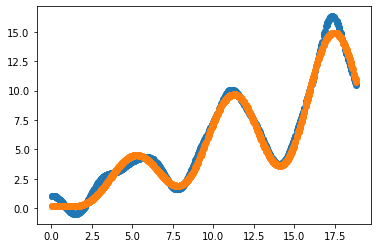

In [43]:
plt.scatter(x_train, y_train)
plt.scatter(x_train, EA_RANK)

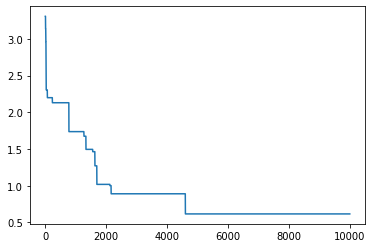

In [58]:
x = [i for i in range(10000)]
plt.plot(x, cur)

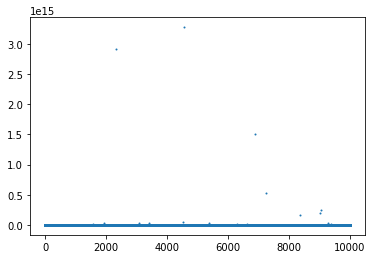

In [48]:
x = []
y = []
for i in range(len(dotList)):
    for j in range(len(dotList[i])):
        x.append(i)
        y.append(dotList[i][j])


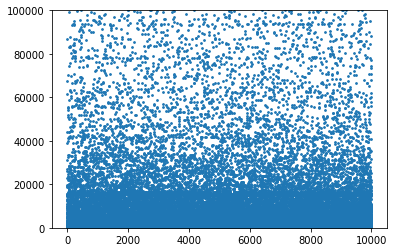

In [55]:
plt.ylim([0, 100000])
plt.scatter(x, y, s=3.0)

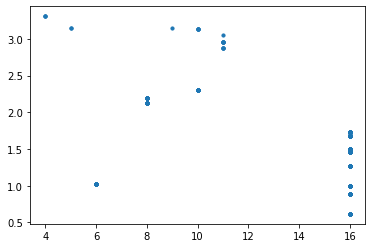

In [50]:
plt.scatter(complexityList, cur, s=10)
